<h1><center>F1 RACE WINNER PREDICTOR</center></h1>
<h1><center>4. Modeling</center></h1>

---

## In this Notebook:

In this Notebook you will find the preliminary cleaning of the data and a quick feature engineering related to the use of dates and qualifying times. 

1. [Data preparation](#1.-Data-preparation)
2. [Tailor-made scoring function](#2.-Tailor-made-scoring-function)
3. [Model selection and tuning](#3.-Model-selection-and-tuning)
4. [2021 season predictions](#4.-2021-season-predictions)  
5. [Feature importance](#5.-Feature-importance)
6. [Next steps](#6.-Next-steps)

The following step after EDA is 4. ML Modelling.

---

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

np.set_printoptions(precision=4)

import warnings
warnings.filterwarnings('ignore')

# 1. Data preparation

In [2]:
# Define what season to use as test set
test_season = 2021

In [3]:
# read data and apply modifications from EDA
data = pd.read_csv('data/df_no_dummies.csv')

# 'win' variable will be our target feature later in the modelling stage
data['win'] = data['podium'].apply(lambda x: 1 if x==1 else 0)

# 'bucketize' the seasons into regulation eras
def era_split(value_in):
    if value_in<=1988:
        value_out = '1.5L_turbo'
    elif value_in<=1994:
        value_out = '3.5L_naturally_aspirated'
    elif value_in<=1999:
        value_out = '3L'
    elif value_in<=2005:
        value_out = 'V10'
    elif value_in<=2013:
        value_out = '2.4L_V8_engines'
    elif value_in<=2021:
        value_out = 'V6_hybrid'
    return value_out
data['reg_era'] = data.season.apply(era_split)

data.drop(columns=['weather_warm','weather_cold', 'weather_dry', 'weather_cloudy', 'weather'], inplace=True)

data = pd.get_dummies(data, columns = ['reg_era'] )

In [4]:
df0 = data.copy()
df0.columns

Index(['season', 'round', 'circuit_id', 'weather_wet', 'driver', 'nationality',
       'constructor', 'grid', 'podium', 'driver_points', 'driver_wins',
       'driver_standings_pos', 'constructor_points', 'constructor_wins',
       'constructor_standings_pos', 'qualifying_time', 'driver_age', 'win',
       'reg_era_1.5L_turbo', 'reg_era_2.4L_V8_engines',
       'reg_era_3.5L_naturally_aspirated', 'reg_era_3L', 'reg_era_V10',
       'reg_era_V6_hybrid'],
      dtype='object')

In [5]:
# account for team rebranding by replacing old names by new names
df0.loc[df0.constructor == "toro_rosso", "constructor"] = "alphatauri"
df0.loc[df0.constructor == "renault", "constructor"] = "alpine"
df0.loc[df0.constructor == "racing_point", "constructor"] = "aston_martin"
df0.loc[df0.constructor == "force_india", "constructor"] = "aston_martin"
#df0.loc[df0.constructor == "force_india", "constructor"] = "racing_point"

In [6]:
# ONLY KEEP 2021-RELEVANT CONSTRUCTORS, DRIVERS AND CIRCUITS

# CONSTRUCTORS ------------------------------------------------------------

#create a list with ALL constructors (after dummification)
all_constr = df0.constructor.unique()
constr_concat_all = ['constructor_' + str(i) for i in all_constr]

#create a list with 2021 constructors (after dummification)
constr_2021_list = list(df0[df0['season'] == test_season]['constructor'].unique())
constr_concat_21 = ['constructor_' + str(i) for i in constr_2021_list]

#subtract the 2021 list from the all list 
constr_to_drop = list([x for x in constr_concat_all if not x in constr_concat_21 or constr_concat_21.remove(x)])
print('The number of dimensions reduced by removing old constructors is ' + str(len(constr_to_drop)))

# DRIVERS -----------------------------------------------------------------

#create a list with all drivers (after dummification)
all_driver = df0.driver.unique()
driver_concat_all = ['driver_' + str(i) for i in all_driver]

#create a list with 2021 constructors (after dummification)
driver_2021_list = list(df0[df0['season'] == test_season]['driver'].unique())
driver_concat_21 = ['driver_' + str(i) for i in driver_2021_list]

#subtract the 2021 list from the all list 
driver_to_drop = list([x for x in driver_concat_all if not x in driver_concat_21 or driver_concat_21.remove(x)])
print('The number of dimensions reduced by removing old drivers is ' + str(len(driver_to_drop)))

# CIRCUITS ----------------------------------------------------------------

#create a list with all circuits (after dummification)
all_circuit = df0.circuit_id.unique()
circuit_concat_all = ['circuit_id_' + str(i) for i in all_circuit]

#create a list with 2021 circuits (after dummification)
circuit_2021_list = list(df0[df0['season'] == test_season]['circuit_id'].unique())
circuit_concat_21 = ['circuit_id_' + str(i) for i in circuit_2021_list]

#subtract the 2021 list from the all list 
circuit_to_drop = list([x for x in circuit_concat_all if not x in circuit_concat_21 or circuit_concat_21.remove(x)])
print('The number of dimensions reduced by removing old cirucits is ' + str(len(circuit_to_drop)))

The number of dimensions reduced by removing old constructors is 55
The number of dimensions reduced by removing old drivers is 210
The number of dimensions reduced by removing old cirucits is 30


In [7]:
# Removing unnecessary columns before dummification
in_model = ['season', 'round', 'circuit_id', 'weather_wet', 'driver',
       'constructor', 'grid', 'driver_points', 'driver_wins',
       'driver_standings_pos', 'constructor_points', 'constructor_wins',
       'constructor_standings_pos', 'qualifying_time', 'driver_age',
       'reg_era_1.5L_turbo', 'reg_era_2.4L_V8_engines',
       'reg_era_3.5L_naturally_aspirated', 'reg_era_3L', 'reg_era_V10',
       'reg_era_V6_hybrid', 'win']
df0 = df0[in_model]

In [8]:
# full df 
df = pd.get_dummies(df0)
df.drop(constr_to_drop, inplace=True, axis=1)
df.drop(driver_to_drop, inplace=True, axis=1)
df.drop(columns='driver_kubica', inplace=True, axis=1) # Kubica was briefly a replacement driver in 2021.
df.drop(circuit_to_drop, inplace=True, axis=1)
print('Total remaining features: ' + str(len(list(df.columns))))

Total remaining features: 71


# 2. Tailor-made scoring function

In [9]:
# Train set (test set is on a per-season basis, created inside the socring function)

train = df[df['season'] < test_season]

X_train = train.drop(columns='win')
y_train = train['win']

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

In [10]:
# scoring function for classification

def score_classification(model, df):
    score = 0
    for race in df[df.season == test_season]['round'].unique():
        
        # test set is the whole test_season
        test = df[(df['season'] == test_season) & (df['round'] == race)]
        X_test = test.drop(['win'], axis = 1)
        y_test = test['win']

        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

        # make predictions
        prediction_df = pd.DataFrame(model.predict_proba(X_test), columns = ['proba_0', 'proba_1'])
        prediction_df['actual'] = y_test.reset_index(drop = True) # reset index
        prediction_df.sort_values(by='proba_1', ascending = False, inplace = True) # sort by proba of winning
        prediction_df.reset_index(inplace = True, drop = True) # reset index again
        prediction_df['predicted'] = prediction_df.index
        prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x == 0 else 0) # winner is the driver with the highest proba

        score += precision_score(prediction_df.actual, prediction_df.predicted) # share of correctly predicted in 2021 season

    model_score = score / df[df.season == test_season]['round'].unique().max() # score = share of correctly predicted test season
    return model_score

# 3. Model selection and tuning

In [11]:
# Initialize grid search results dict
results_dict = {'model':[], 'params': [], 'score': []}

In [12]:
# Logistic Regression

param_grid={'penalty': ['l1', 'l2'],
        'solver': ['saga', 'liblinear'],
        'C': np.logspace(-3,1,20)} # np.logspace(start, stop, number_of_samples) returns numbers evenly spaced on a log scale

for penalty in param_grid['penalty']:
    for solver in param_grid['solver']:
        for c in param_grid['C']:
            model_params = (penalty, solver, c)
            model = LogisticRegression(penalty = penalty, solver = solver, C = c, max_iter = 10000, n_jobs=-1)
            model.fit(X_train, y_train)
            
            model_score = score_classification(model, df=df)
            
            results_dict['model'].append('logistic_regression')
            results_dict['params'].append(model_params)
            results_dict['score'].append(model_score)

In [13]:
# Extreme Gradient Boosting (XGBoost)

param_grid={'max_depth': [2, 3, 4, 5],
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.1, 0.2, 0.05]}

for max_depth in param_grid['max_depth']:
    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            model_params = (max_depth, n_estimators, learning_rate)
            model = XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, n_jobs=-1)
            model.fit(X_train, y_train)
            
            model_score = score_classification(model, df=df)
            
            results_dict['model'].append('XGBoost_classifier')
            results_dict['params'].append(model_params)
            results_dict['score'].append(model_score)

[01:14:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:14:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:14:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[01:15:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:15:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:15:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [14]:
# Support Vector Machines (takes 6+ hours to train)

param_grid={'gamma': np.logspace(-4, -1, 20), # np.logspace(start, stop, number_of_samples) returns numbers evenly spaced on a log scale
        'C': np.logspace(-2, 1, 20), # np.logspace(start, stop, number_of_samples) returns numbers evenly spaced on a log scale
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

for gamma in param_grid['gamma']:
    for c in param_grid['C']:
        for kernel in param_grid['kernel']:
            model_params = (gamma, c, kernel)
            model = svm.SVC(probability = True, gamma = gamma, C = c, kernel = kernel)
            model.fit(X_train, y_train)
            
            model_score = score_classification(model, df=df)
            
            results_dict['model'].append('svm_classifier')
            results_dict['params'].append(model_params)
            results_dict['score'].append(model_score)

In [15]:
# Random Forest Classifier

param_grid={'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2', None],
        'max_depth': list(np.linspace(5, 55, 26)) + [None]} # np.logspace(start, stop, number_of_samples) returns numbers evenly spaced on a log scale

for criterion in param_grid['criterion']:
    for max_features in param_grid['max_features']:
        for max_depth in param_grid['max_depth']:
            model_params = (criterion, max_features, max_depth)
            model = RandomForestClassifier(criterion = criterion, max_features = max_features, max_depth = max_depth, n_jobs=-1)
            model.fit(X_train, y_train)
            
            model_score = score_classification(model, df=df)
            
            results_dict['model'].append('random_forest_classifier')
            results_dict['params'].append(model_params)
            results_dict['score'].append(model_score)

In [16]:
# Neural Networks? To come soon, need GPU :)

In [17]:
results_df = pd.DataFrame(results_dict).sort_values('score', ascending=False).reset_index(drop=True)
results_df.head(10)

,model,params,score
0,svm_classifier,"(0.0012742749857031334, 0.01, rbf)",0.636364
1,random_forest_classifier,"(gini, log2, 15.0)",0.636364
2,svm_classifier,"(0.00042813323987193956, 10.0, sigmoid)",0.636364
3,svm_classifier,"(0.0012742749857031334, 3.359818286283781, sig...",0.636364
4,svm_classifier,"(0.0012742749857031334, 0.0206913808111479, rbf)",0.636364
5,logistic_regression,"(l1, saga, 2.3357214690901213)",0.590909
6,random_forest_classifier,"(gini, sqrt, None)",0.590909
7,random_forest_classifier,"(gini, None, 25.0)",0.590909
8,random_forest_classifier,"(gini, log2, 35.0)",0.590909
9,logistic_regression,"(l1, saga, 1.438449888287663)",0.590909


In [18]:
results_df.to_csv('data/gridsearch_results_' + str(test_season) + '.csv')

Model Tuning Observations:

- The models that best perform are the Random Forest Classifierand the SVC Classifier. The SVM with a kernel is generally a very powerful classification model that sometimes competes with neural networks. The random forest was expected to perform well tree-based classification models tend to shine when there is a large number of dummy variables, as they work with a yes/no decision tree system.
- The model managed to earn a precision score of 0.636

In [19]:
# best score by model
results_df.groupby('model')['score'].max().sort_values(ascending=False)

model
random_forest_classifier    0.636364
svm_classifier              0.636364
XGBoost_classifier          0.590909
logistic_regression         0.590909
Name: score, dtype: float64

In [20]:
# score mean by model
results_df.groupby('model')['score'].mean().sort_values(ascending=False)

model
XGBoost_classifier          0.510101
random_forest_classifier    0.463244
logistic_regression         0.453409
svm_classifier              0.324858
Name: score, dtype: float64

In [21]:
# score std by model
results_df.groupby('model')['score'].std().sort_values(ascending=True)

model
XGBoost_classifier          0.060606
random_forest_classifier    0.065181
logistic_regression         0.085872
svm_classifier              0.096108
Name: score, dtype: float64

<AxesSubplot:>

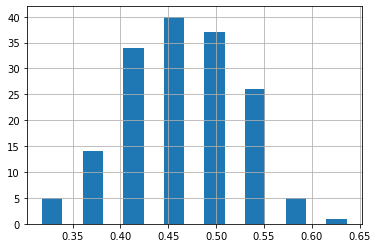

In [22]:
# score distribution: random forest
results_df[results_df['model'] == 'random_forest_classifier'].score.hist(bins=15)

<AxesSubplot:>

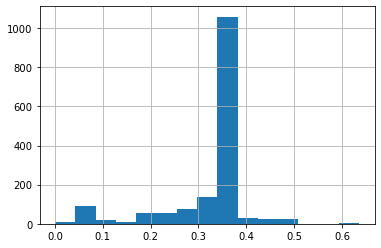

In [23]:
# score distribution: svm
results_df[results_df['model'] == 'svm_classifier'].score.hist(bins=15)

# 4. 2021 season predictions

In [33]:
# Best model results - Random Forest Classifier or SVM Classifier

best_params = list(results_df.iloc[0,1]) # fetch the best parameters from results_df

#choosing the best model according to GridSearch
if results_df.iloc[0,0] == 'random_forest_classifier':
    model = RandomForestClassifier(criterion=best_params[0], max_features=best_params[1], max_depth=best_params[2], n_jobs=-1, random_state=8)
elif results_df.iloc[0,0] == 'svm_classifier':
    model = svm.SVC(probability = True, gamma = best_params[0], C = best_params[1], kernel = best_params[2])

print('Model used: ' + str(results_df.iloc[0,0]))

model.fit(X_train, y_train)

race_predictions = []

for race in df[df.season == test_season]['round'].unique():
        
    # test set is the whole test_season
    test = df[(df['season'] == test_season) & (df['round'] == race)]
    X_test = test.drop(['win'], axis = 1)
    y_test = test['win']
    
    #scaling
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
    
    # make predictions
    prediction = rfc.predict_proba(X_test)
    
    prediction_df = pd.DataFrame(test)
    prediction_df['Target'] = y_test
    prediction_df['proba_not_win'] = prediction[:,0] 
    prediction_df['proba_win'] = prediction[:,1]
    
    #prediction_df['actual'] = y_test.reset_index(drop = True) # reset index
    prediction_df.sort_values(by='proba_win', ascending = False, inplace = True) # sort by proba of winning
    prediction_df.reset_index(inplace = True, drop = True) # reset index again
    prediction_df['predicted'] = prediction_df.index
    prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x == 0 else 0) # winner is the driver with the highest proba
    prediction_df['round'] = int(race)
    
    race_predictions.append(prediction_df)

prediction_df = pd.concat(race_predictions) # concatenate all predictions for all races into one DataFrame

Model used: svm_classifier


In [34]:
# Undummification of some cat features to construct the final summary table

# drivers
drivers = [item for item in df.columns if 'driver_' in item] # create list of drivers for undummification
drivers.remove('driver_points')
drivers.remove('driver_wins')
drivers.remove('driver_standings_pos')
drivers.remove('driver_age')
drivers_no_dummies = list(prediction_df[drivers].idxmax(axis=1))
prediction_df['driver'] = drivers_no_dummies
prediction_df['driver'] = prediction_df['driver'].apply(lambda x: x.split('_')[-1])

# constructors
constructors = [item for item in df.columns if 'constructor_' in item] # create list of constructors for undummification
constructors.remove('constructor_points')
constructors.remove('constructor_wins')
constructors.remove('constructor_standings_pos')
constructors_no_dummies = list(prediction_df[constructors].idxmax(axis=1))
prediction_df['constructor'] = constructors_no_dummies
prediction_df['constructor'] = prediction_df['constructor'].apply(lambda x: x.replace('constructor_', ''))

# circuits
circuits = [item for item in df.columns if 'circuit_id_' in item] # create list of circuits for undummification
circuits_no_dummies = list(prediction_df[circuits].idxmax(axis=1))
prediction_df['circuit'] = circuits_no_dummies
prediction_df['circuit'] = prediction_df['circuit'].apply(lambda x: x.replace('circuit_id_', ''))

In [42]:
# Putting together the final summary Table

summary = prediction_df[prediction_df['predicted'] == 1].sort_values(by='round').reset_index(drop=True)
win_df = prediction_df[prediction_df['win'] == 1].sort_values(by='round')
predicted_df = prediction_df[prediction_df['predicted'] == 1].sort_values(by='round')
pole_df = prediction_df[prediction_df['grid'] == 1].sort_values(by='round')

# driver_won 
driver_won = list(win_df['driver'])
summary['driver_won'] = driver_won
# driver _predicted
driver_predicted = list(predicted_df['driver'])
summary['driver_predicted'] = driver_predicted
# driver_on_pole
driver_on_pole = list(pole_df['driver'])
summary['driver_on_pole'] = driver_on_pole

summary = summary[['season', 'round', 'circuit', 'driver_on_pole', 'driver_won', 'driver_predicted']]
summary.to_csv('data/prediction_summary_' + str(test_season) + '.csv')
summary

,season,round,circuit,driver_on_pole,driver_won,driver_predicted
0,2021,1,bahrain,verstappen,hamilton,hamilton
1,2021,2,imola,hamilton,verstappen,hamilton
2,2021,3,portimao,bottas,hamilton,hamilton
3,2021,4,catalunya,hamilton,hamilton,hamilton
4,2021,5,monaco,leclerc,verstappen,leclerc
5,2021,6,baku,leclerc,perez,leclerc
6,2021,7,ricard,verstappen,verstappen,verstappen
7,2021,8,red_bull_ring,verstappen,verstappen,verstappen
8,2021,9,red_bull_ring,verstappen,verstappen,verstappen
9,2021,10,silverstone,verstappen,hamilton,verstappen


## 5. Feature importance

* It makes sense that the qualifying result ('grid') be disproportionately more important than other features because it is chronologically the closest event to the actual race, specially in circuits where overtaking is more difficult. It is an indication of a driver's performance in 'lab conditions', without attacking, deffending, or managing tyres. 
* The accumulated constructor and driver points are an indication of how likely is this driver to win given its positions in the past races of the season. They contain the year-to-date performance of a driver/constructor in a single number.
* Similarly, the driver's age is a proxy for their tenure or experience in F1 (the two are extremely correlated). It is the all-time hisory of the driver. 
* Weather_wet turned out to be way less important than expected.

In [47]:
# Feature importance from a random forest based on mean decrease in impurity (mdi)

forest_importances = pd.DataFrame(data=rfc.feature_importances_, index=X_train.columns, columns=['mdi_importance']).sort_values(by='mdi_importance', ascending=False).reset_index(inplace=False).head(13)
forest_importances.rename(columns = {'index':'feature_name'}, inplace = True)

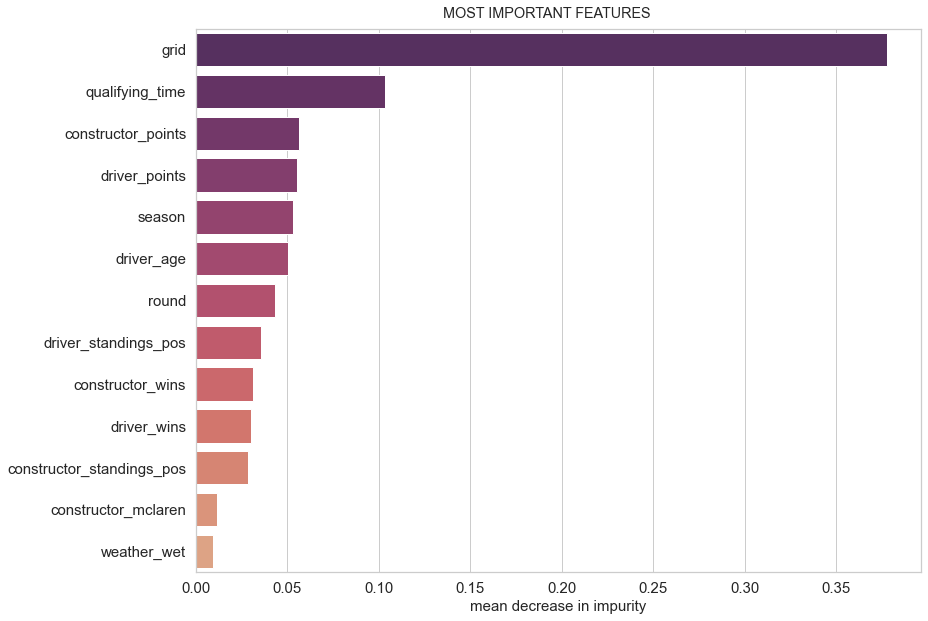

In [43]:
# plot 

plt.figure(figsize=(13,10))
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=forest_importances, x='mdi_importance', y='feature_name', palette='flare_r')
ax.set_xlabel ('mean decrease in impurity', fontsize=15) # drop x-axis label because it's distracting
ax.set_ylabel ('') # drop y-axis label because it's distracting
ax.tick_params(labelsize=15)

plt.suptitle("MOST IMPORTANT FEATURES", y=0.91)
plt.savefig('images/feature_importance_mdi.png')
plt.show()

## 6. Next steps

- Using a GPU, build a Neural Network to hopefully improve the quality of our predictions.
- Use Variance Inflation Factor (VIF) to check for multicollinearity.
- While estimating the probability of winning, we set teh driver with the higest probability as the winner. What if we calculated the percentage difference between the predicted winner and the predicted P2? This could give us a sense of how certain the model is about its prediction for a given race.